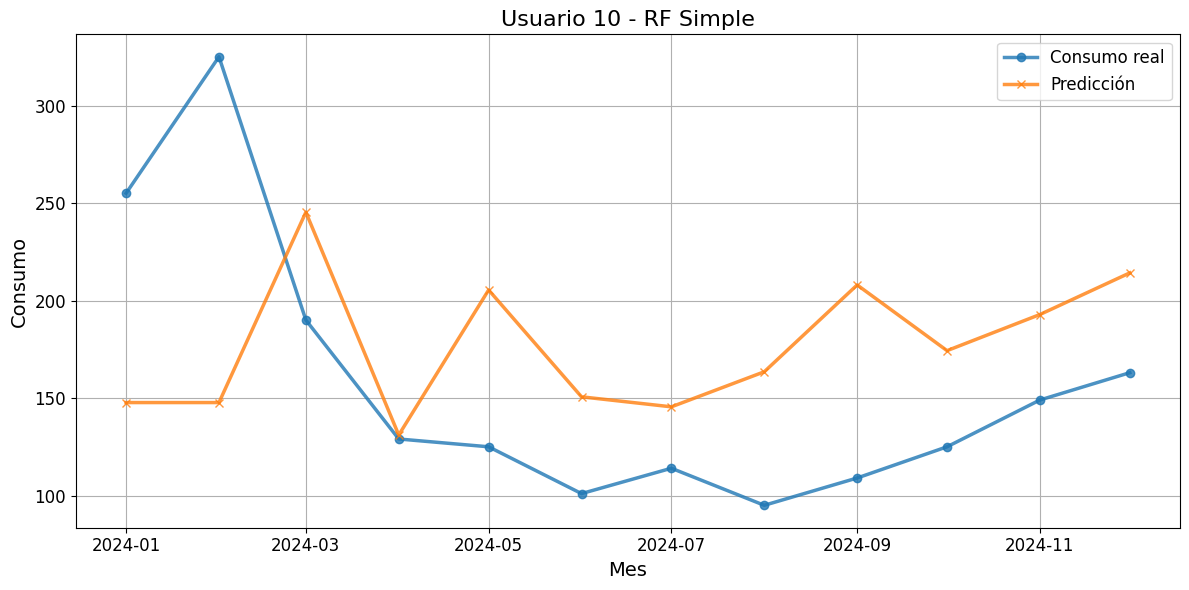

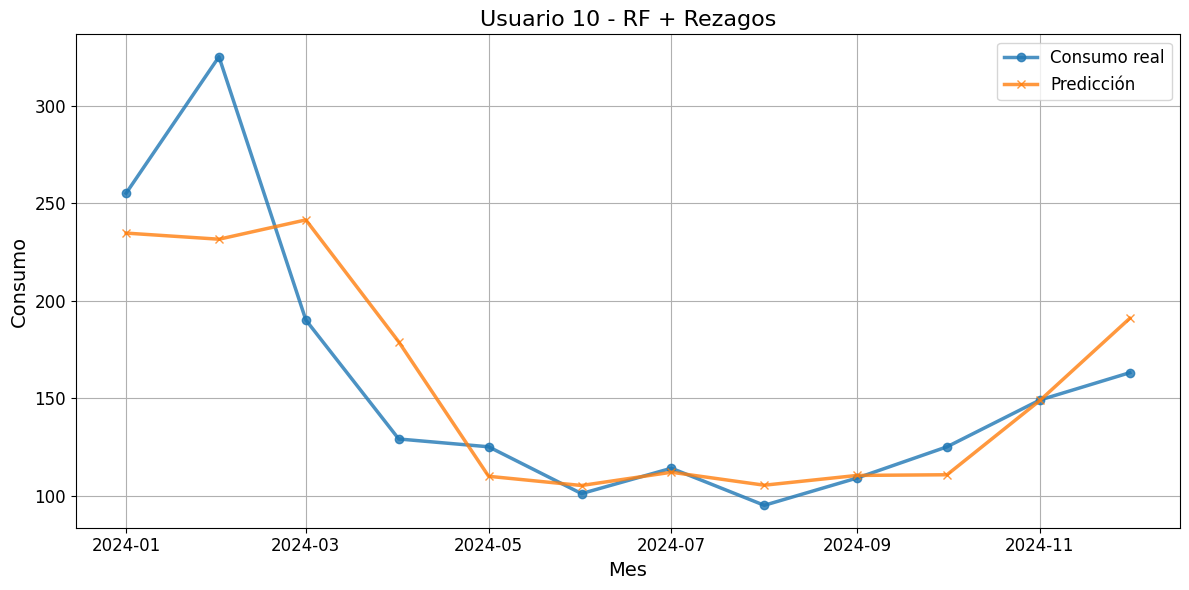

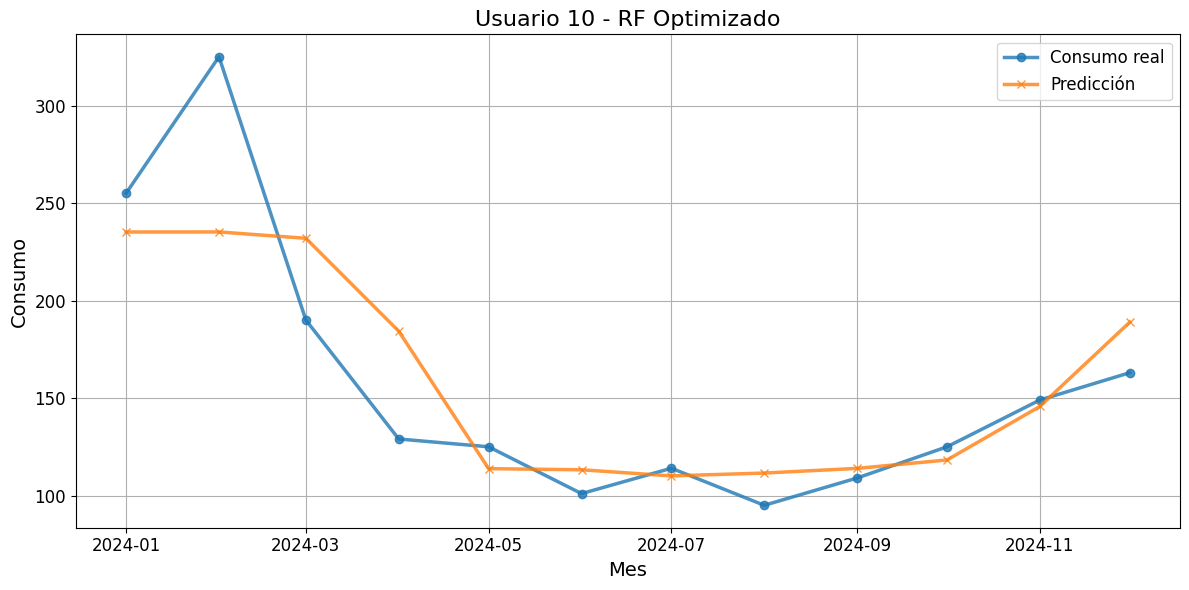

CSV real vs pred generado: consumo_real_vs_pred_RF_1_2024.csv

Frecuencia de combinaciones de hiperparámetros usados en RF Optimizado:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}: 1 veces

Mejor combinación de hiperparámetros por usuario:
Usuario 10: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}


In [1]:
# Librerías necesarias (RF simple / RF rezagos / RF optimizado)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import warnings
from collections import Counter

warnings.filterwarnings("ignore")

# ================================
# PARAMETROS DE ESTILO (EDITABLES)
# ================================
STYLE = {
    "fontsize_title": 16,
    "fontsize_axes": 14,
    "fontsize_ticks": 12,
    "fontsize_legend": 12,
    "linewidth_real": 2.5,
    "linewidth_pred": 2.5,
    "markersize": 6,
    "alpha": 0.8
}

# ================================
# Cargar datos
# ================================
ruta_archivo = "CON_TEMPU1.csv"
caso = ruta_archivo[9:-4]  # para CON_TEMPU1.csv -> "1"

datos = pd.read_csv(ruta_archivo, sep=";", decimal=",")
datos["fecha"] = pd.to_datetime(
    datos["ano"].astype(str) + "-" + datos["mes"].astype(str).str.zfill(2) + "-01"
)
datos.sort_values(by=["usuario", "fecha"], inplace=True)

# Filtrar usuarios con datos completos (74 meses)
usuarios_validos = datos["usuario"].value_counts()
usuarios_validos = usuarios_validos[usuarios_validos == 74].index.tolist()
datos = datos[datos["usuario"].isin(usuarios_validos)].copy()

# =========================
# Funciones auxiliares
# =========================
def calcular_errores(y_real, y_pred):
    y_real = np.asarray(y_real)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_real) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan, np.nan, np.nan
    mae = mean_absolute_error(y_real[mask], y_pred[mask])
    mse = mean_squared_error(y_real[mask], y_pred[mask])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def graficar_predicciones(fechas, y_real, y_pred, titulo):
    plt.figure(figsize=(12, 6))

    plt.plot(
        fechas, y_real,
        label="Consumo real",
        marker="o",
        markersize=STYLE["markersize"],
        linewidth=STYLE["linewidth_real"],
        alpha=STYLE["alpha"]
    )

    plt.plot(
        fechas, y_pred,
        label="Predicción",
        marker="x",
        markersize=STYLE["markersize"],
        linewidth=STYLE["linewidth_pred"],
        alpha=STYLE["alpha"]
    )

    plt.title(titulo, fontsize=STYLE["fontsize_title"])
    plt.xlabel("Mes", fontsize=STYLE["fontsize_axes"])
    plt.ylabel("Consumo", fontsize=STYLE["fontsize_axes"])

    plt.xticks(fontsize=STYLE["fontsize_ticks"])
    plt.yticks(fontsize=STYLE["fontsize_ticks"])

    plt.legend(fontsize=STYLE["fontsize_legend"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =========================
# Estructuras de salida
# =========================
errores = []
predicciones_enero = []
hp_freq = []
mejores_parametros = {}

# Para guardar "lo graficado" (real vs pred)
series_graficadas = []  # se concatena al final

# =========================
# Loop por usuario
# =========================
for usuario in usuarios_validos:
    df_u = datos[datos["usuario"] == usuario].copy()
    df_u.set_index("fecha", inplace=True)
    df_u = df_u.asfreq("MS")  # mensual

    # --- Definir train/validación (2024) ---
    train = df_u[df_u.index < "2024-01-01"].copy()
    valid = df_u.loc["2024-01-01":"2024-12-01"].copy()

    # Si faltan datos clave, saltar usuario
    if train[["temperatura", "consumo"]].isna().any().any() or valid[["temperatura", "consumo"]].isna().any().any():
        # Podés cambiar esto por un tratamiento de faltantes si lo necesitás
        continue

    fechas_2024 = valid.index
    y_real = valid["consumo"].values

    # =========================
    # 1) RF Simple (temperatura)
    # =========================
    X_train = train[["temperatura"]]
    y_train = train["consumo"]
    X_valid = valid[["temperatura"]]

    modelo_rf = RandomForestRegressor(random_state=0)
    modelo_rf.fit(X_train, y_train)

    pred_rf = modelo_rf.predict(X_valid)

    mae, mse, rmse = calcular_errores(y_real, pred_rf)
    errores.append([usuario, "RF", mae, mse, rmse])

    # Guardar serie graficada (RF)
    series_graficadas.append(pd.DataFrame({
        "usuario": usuario,
        "modelo": "RF",
        "fecha": fechas_2024,
        "consumo_real": y_real,
        "prediccion": pred_rf
    }))

    graficar_predicciones(fechas_2024, y_real, pred_rf, f"Usuario {usuario} - RF Simple")

    # Predicción enero 2025 (asumiendo temp enero = temp dic 2024)
    temp_enero = df_u.loc["2024-12-01", "temperatura"]
    pred_ene_rf = modelo_rf.predict([[temp_enero]])[0]
    predicciones_enero.append([usuario, "RF", pred_ene_rf])

    # =========================
    # 2) RF con rezagos (temp + lag1 + lag12)
    # =========================
    df_lags = df_u.copy()
    df_lags["lag1"] = df_lags["consumo"].shift(1)
    df_lags["lag12"] = df_lags["consumo"].shift(12)
    df_lags = df_lags.dropna(subset=["temperatura", "consumo", "lag1", "lag12"])

    train_lag = df_lags[df_lags.index < "2024-01-01"].copy()
    valid_lag = df_lags.loc["2024-01-01":"2024-12-01"].copy()

    if len(train_lag) == 0 or len(valid_lag) == 0:
        continue

    X_train_lag = train_lag[["temperatura", "lag1", "lag12"]]
    y_train_lag = train_lag["consumo"]
    X_valid_lag = valid_lag[["temperatura", "lag1", "lag12"]]
    y_real_lag = valid_lag["consumo"].values
    fechas_2024_lag = valid_lag.index

    modelo_rf_lag = RandomForestRegressor(random_state=0)
    modelo_rf_lag.fit(X_train_lag, y_train_lag)

    pred_rf_lag = modelo_rf_lag.predict(X_valid_lag)

    mae, mse, rmse = calcular_errores(y_real_lag, pred_rf_lag)
    errores.append([usuario, "RF_Lag", mae, mse, rmse])

    series_graficadas.append(pd.DataFrame({
        "usuario": usuario,
        "modelo": "RF_Lag",
        "fecha": fechas_2024_lag,
        "consumo_real": y_real_lag,
        "prediccion": pred_rf_lag
    }))

    graficar_predicciones(fechas_2024_lag, y_real_lag, pred_rf_lag, f"Usuario {usuario} - RF + Rezagos")

    # Predicción enero 2025 con rezagos:
    # lag1 = consumo dic 2024, lag12 = consumo ene 2024
    lag1 = df_u.loc["2024-12-01", "consumo"]
    lag12 = df_u.loc["2024-01-01", "consumo"]
    X_enero_lag = [[temp_enero, lag1, lag12]]
    pred_ene_lag = modelo_rf_lag.predict(X_enero_lag)[0]
    predicciones_enero.append([usuario, "RF_Lag", pred_ene_lag])

    # =========================
    # 3) RF Optimizado (sobre rezagos)
    # =========================
    param_dist = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }

    busqueda = RandomizedSearchCV(
        RandomForestRegressor(random_state=0),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        random_state=0
    )

    busqueda.fit(X_train_lag, y_train_lag)
    mejor_modelo = busqueda.best_estimator_

    pred_opt = mejor_modelo.predict(X_valid_lag)

    mae, mse, rmse = calcular_errores(y_real_lag, pred_opt)
    errores.append([usuario, "RF_Opt", mae, mse, rmse])

    series_graficadas.append(pd.DataFrame({
        "usuario": usuario,
        "modelo": "RF_Opt",
        "fecha": fechas_2024_lag,
        "consumo_real": y_real_lag,
        "prediccion": pred_opt
    }))

    graficar_predicciones(fechas_2024_lag, y_real_lag, pred_opt, f"Usuario {usuario} - RF Optimizado")

    pred_ene_opt = mejor_modelo.predict(X_enero_lag)[0]
    predicciones_enero.append([usuario, "RF_Opt", pred_ene_opt])

    hp_freq.append(str(busqueda.best_params_))
    mejores_parametros[usuario] = busqueda.best_params_

# =========================
# Guardar resultados (RFs)
# =========================
errores_df = pd.DataFrame(errores, columns=["usuario", "modelo", "MAE", "MSE", "RMSE"])
predicciones_df = pd.DataFrame(predicciones_enero, columns=["usuario", "modelo", "prediccion_enero_2025"])

# Guardar con ; y 2 decimales (coma decimal)
errores_df.to_csv(f"errores_modelo{caso}.csv", sep=";", index=False, float_format="%.2f", decimal=",")
predicciones_df.to_csv(f"predicciones_enero_2025{caso}.csv", sep=";", index=False, float_format="%.2f", decimal=",")

# ===============================================================
# Guardar "consumo real vs predicción" (lo graficado)
# Formato largo: usuario, modelo, fecha, consumo_real, prediccion
# ===============================================================
if len(series_graficadas) > 0:
    real_vs_pred_df = pd.concat(series_graficadas, ignore_index=True)
    real_vs_pred_df["fecha"] = pd.to_datetime(real_vs_pred_df["fecha"]).dt.strftime("%Y-%m-%d")

    out_file = f"consumo_real_vs_pred_RF_{caso}_2024.csv"
    real_vs_pred_df.to_csv(out_file, sep=";", index=False, float_format="%.2f", decimal=",", na_rep="")
    print("CSV real vs pred generado:", out_file)

# =========================
# Reportes (RF Optimizado)
# =========================
print("\nFrecuencia de combinaciones de hiperparámetros usados en RF Optimizado:")
for k, v in Counter(hp_freq).most_common():
    print(f"{k}: {v} veces")

print("\nMejor combinación de hiperparámetros por usuario:")
for usuario, params in mejores_parametros.items():
    print(f"Usuario {usuario}: {params}")
